<a href="https://colab.research.google.com/github/DannyTheFlower/PDA_Course/blob/main/practices/practice_5/PDA_P5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Постановка задачи и загрузка данных

В данной практической работе мы будем решать задачу сегментации изображений на примере датасета `PH2Dataset`. Данный датасет представляет собой медицинские снимки двух типов поражений кожи: родинки и меланомы. В рамках практической работы будем заниматься их сегментацией.

In [ ]:
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json
!echo '{"username":"daniilpiatygo","key":"6a5c15c37176a5dd0af08791f3882e69"}' > /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d kanametov/ph2dataset

100% 202M/203M [00:12<00:00, 21.4MB/s]
100% 203M/203M [00:12<00:00, 17.2MB/s]


In [ ]:
!unzip -q ph2dataset.zip

Как можно видеть, датасет имеет следующую структуру:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Загрузим эти изображения в переменные.

In [ ]:
from skimage.io import imread, imshow
import os

images = []
lesions = []
BASE_DIR = "/content/PH2Dataset/PH2_Dataset"

for root, dirs, files in os.walk(BASE_DIR):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
print(f"Количество изображений: {len(images)}")

Количество изображений: 200


Посмотрим на полученный результат.

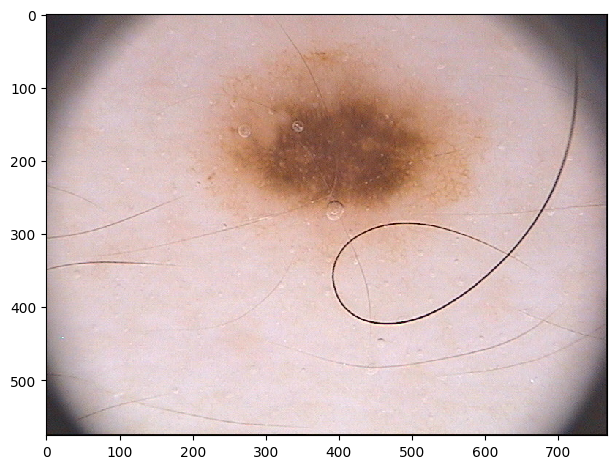

In [ ]:
imshow(images[0])

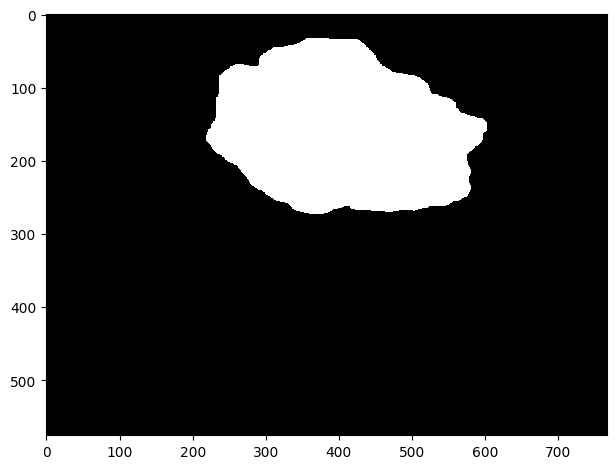

In [ ]:
imshow(lesions[0])

# Предобработка

Посмотрим на размерность изображений:

In [ ]:
heights_images = [img.shape[0] for img in images]
widths_images = [img.shape[1] for img in images]

min_height_images, max_height_images = min(heights_images), max(heights_images)
min_width_images, max_width_images = min(widths_images), max(widths_images)

print(f"Диапазон высот: {min_height_images} - {max_height_images} пикселей")
print(f"Диапазон ширин: {min_width_images} - {max_width_images} пикселей")

Диапазон высот: 553 - 577 пикселей
Диапазон ширин: 761 - 769 пикселей


Можно выбрать размер, который близок ко всем изображениям, например, 550x760 пикселей (чтобы минимизировать потерю информации) или стандартный размер, например, 256x256 пикселей (если модель машинного обучения требует такой размер).
Для работы с изображениями необходимо привести их к одному размеру и нормализовать (например, с помощью `skimage.transform.resize()`).

In [ ]:
from skimage.transform import resize

size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

Снова посмотрим на результат.

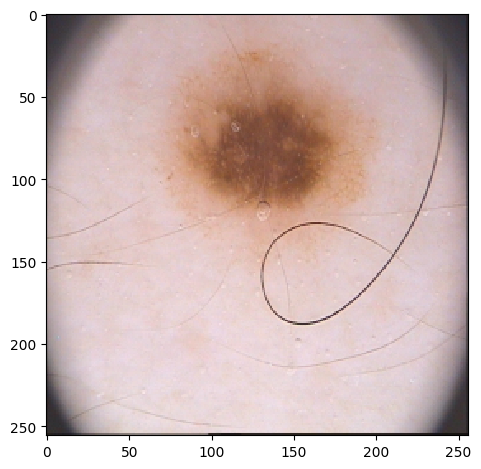

In [ ]:
imshow(X[0])

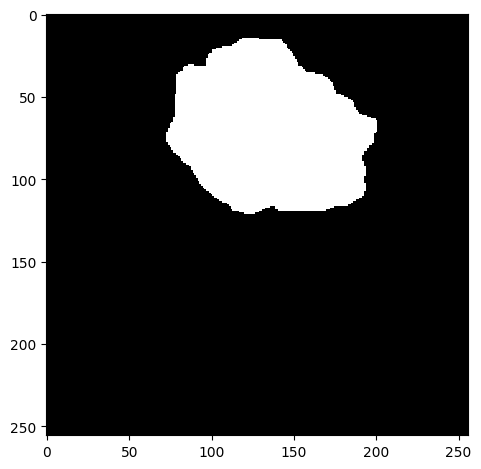

In [ ]:
imshow(Y[0])

# Обучение

Разделим данные (200 изображений) на тренировочные, тестовые и валидационные в отношении 100/50/50 и инициализируем DataLoader'ы.

In [ ]:
%%capture
!pip install segmentation_models_pytorch torchmetrics

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import torch.optim as optim

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torchmetrics.classification import BinaryJaccardIndex

X имеет 4 измерения (количество изображений, высота, ширина, количество каналов) и Y имеет 3 измерения (количество изображений, высота, ширина).

In [ ]:
import numpy as np

X = np.stack(X).astype(np.float32)
Y = np.stack(Y).astype(np.float32)
Y = (Y > 0.5).astype(np.float32)

X_tensor = torch.tensor(X).permute(0, 3, 1, 2)
Y_tensor = torch.tensor(Y).unsqueeze(1)

dataset = TensorDataset(X_tensor, Y_tensor)
train_size = 100
test_size = 50
val_size = 50
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

Определим метрику качества. Для задачи сегментации удачным решением будет использовать IoU (Intersect over Union, известная также, как коэффициент Жаккара):

$\text{IoU}=\frac{\text{target } \cap \text{ prediction}}{\text {target } \cup \text{ prediction}}$

Иначе говоря, мы делим число совпавших пикселей в предсказанной и истинной маске на количество пикселей в объединении этих масок.

In [ ]:
metric = BinaryJaccardIndex()

Обучим модель сегментации с помощью готовой архитектуры U-Net с функцией потерь DiceLoss и оптимизатором Adam.

In [ ]:
encoder = "timm-efficientnet-b0"
weights = "imagenet"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 25
lr = 0.0003
metric.to(device)

BinaryJaccardIndex()

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.architecture = smp.Unet(
            encoder_name = encoder,
            encoder_weights=weights,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.architecture(images)

        if masks is not None:
            loss1 = DiceLoss(mode="binary")(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2

        return logits

In [ ]:
model = SegmentationModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 285MB/s]


In [ ]:
def train_model():
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            logits, loss = model(images, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                logits, loss = model(images, masks)
                val_loss += loss.item()

            val_loss /= len(val_loader)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

In [ ]:
def eval_model():
    model.eval()

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            metric(preds.int(), masks.int())

    return metric.compute().item()

In [ ]:
def predict(image):
    image_resized = resize(image, size, mode="constant", anti_aliasing=True)
    x = torch.tensor([image_resized]).float().permute(0, 3, 1, 2).to(device)

    model.eval()
    with torch.no_grad():
        output = model(x)
        preds = torch.sigmoid(output) > 0.5

    return preds.squeeze(0).permute(1, 2, 0).cpu()

In [ ]:
train_model()

Epoch 1/25, Train Loss: 1.0396, Val Loss: 5.0599
Epoch 2/25, Train Loss: 0.8603, Val Loss: 2.6598
Epoch 3/25, Train Loss: 0.8000, Val Loss: 1.0944
Epoch 4/25, Train Loss: 0.6170, Val Loss: 0.7106
Epoch 5/25, Train Loss: 0.5362, Val Loss: 0.6443
Epoch 6/25, Train Loss: 0.4911, Val Loss: 0.6021
Epoch 7/25, Train Loss: 0.4244, Val Loss: 0.5380
Epoch 8/25, Train Loss: 0.3775, Val Loss: 0.4609
Epoch 9/25, Train Loss: 0.3477, Val Loss: 0.3883
Epoch 10/25, Train Loss: 0.3107, Val Loss: 0.3336
Epoch 11/25, Train Loss: 0.2717, Val Loss: 0.3085
Epoch 12/25, Train Loss: 0.2546, Val Loss: 0.2923
Epoch 13/25, Train Loss: 0.2493, Val Loss: 0.2820
Epoch 14/25, Train Loss: 0.2311, Val Loss: 0.2623
Epoch 15/25, Train Loss: 0.2472, Val Loss: 0.2531
Epoch 16/25, Train Loss: 0.1971, Val Loss: 0.2401
Epoch 17/25, Train Loss: 0.2253, Val Loss: 0.2330
Epoch 18/25, Train Loss: 0.2233, Val Loss: 0.2469
Epoch 19/25, Train Loss: 0.1811, Val Loss: 0.2582
Epoch 20/25, Train Loss: 0.2303, Val Loss: 0.2259
Epoch 21/

# Результаты

Оценим качество модели.

In [ ]:
eval_model()

0.8667623400688171

Посмотрим на несколько экземпляров.

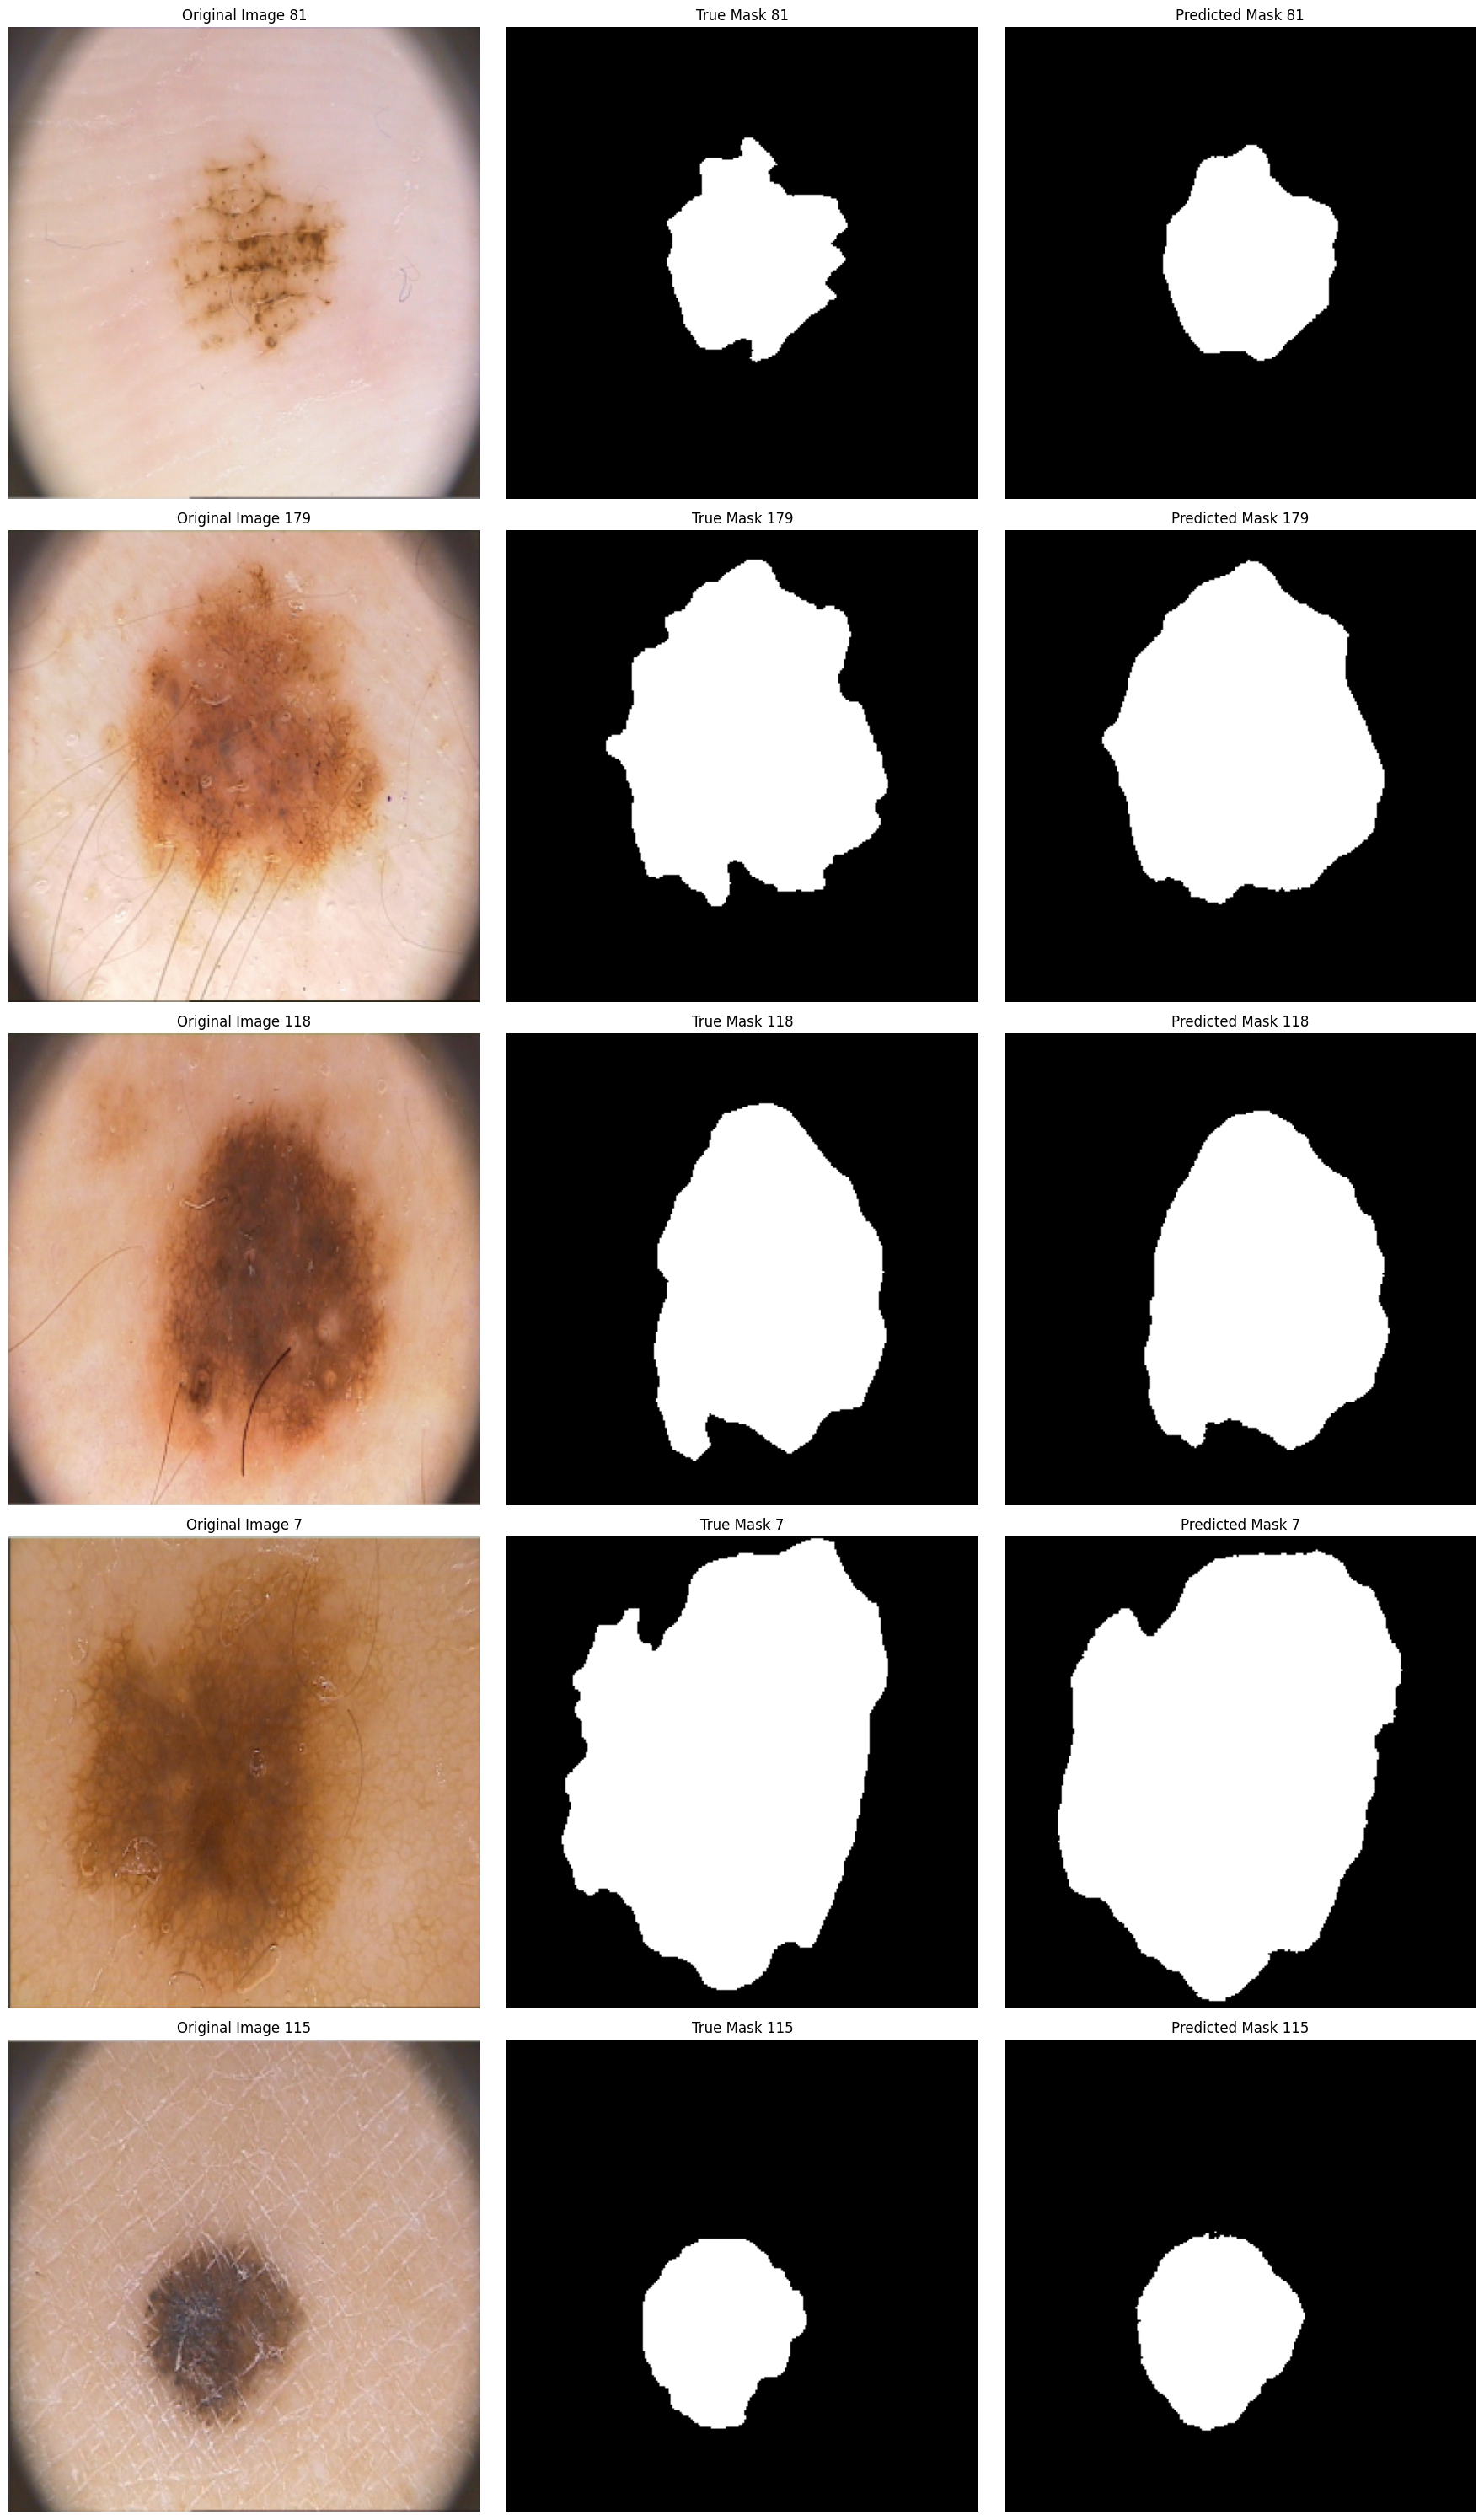

In [ ]:
import random
import matplotlib.pyplot as plt

size = (256, 256)

random_indices = random.sample(range(len(images)), 5)

fig, axes = plt.subplots(5, 3, figsize=(18, 30))

for i, idx in enumerate(random_indices):
    img = resize(images[idx], size, mode="constant", anti_aliasing=True)
    mask_true = resize(lesions[idx], size, mode="constant", anti_aliasing=False)
    mask_pred = predict(img)

    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Original Image {idx}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(mask_true, cmap="gray")
    axes[i, 1].set_title(f"True Mask {idx}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(mask_pred, cmap="gray")
    axes[i, 2].set_title(f"Predicted Mask {idx}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()

На вид качество неплохое, однако метрику явно нужно улучшать, как минимум, до 0.9. Это можно сделать разными способами:

1. Подбор гиперпараметров таких как количество эпох, скорость обучения (learning rate), размер мини-пакета (batch size).

2. Увеличение количества и разнообразия обучающих данных с помощью аугментации может способствовать улучшению обобщающей способности модели. Повороты на разные углы, отзеркаливание, масштабирование, смещение, изменение яркости и контрастности — это лишь некоторые примеры техник, которые могут быть применены.

3. Чтобы предотвратить переобучение, можно применить методы регуляризации, такие как L1, L2, Dropout, Batch Normalization.

Стоит отметить, что модель показала себя хорошо и имеет хороший потенциал для дальнейшего обучения.